### Please install the required Python modules/SDKs

In [1]:
! activate ai-azure-c1

import sys

sys.path.append("/opt/conda/envs/ai-azure-c1/lib/python3.8/site-packages")

Could not find conda environment: ai-azure-c1
You can list all discoverable environments with `conda info --envs`.



### This demo uses the latest pillow package to show the rectangular bounding box around the face, so please upgrade the pillow package using the command below:

In [2]:
!pip install Pillow==8.4

## Importing Useful Python Libraries or Packages 

In [3]:
from PIL import Image
import requests
import glob, os, sys, time, uuid

import matplotlib.pyplot as plt
%matplotlib inline

from io import BytesIO
from PIL import Image, ImageDraw


In [4]:
from azure.cognitiveservices.vision.face import FaceClient
from azure.cognitiveservices.vision.face.models import TrainingStatusType
from msrest.authentication import CognitiveServicesCredentials

## Accessing Specific Azure Resources 

In [5]:
AVKASH_FACE_KEY = "71307f07768144d6a76ee103b05d321d"
AVKASH_FACE_ENDPOINT = "https://nayana-face-api.cognitiveservices.azure.com/"

In [6]:
# Create a client
face_client = FaceClient(AVKASH_FACE_ENDPOINT, CognitiveServicesCredentials(AVKASH_FACE_KEY))

In [7]:
face_client.api_version

'1.0'

## Let's take a look at the 4 images we have

* You must be wondering where I got these 4 face images. Actually, these 4 faces were extracted from a video that was processed using the Azure Video Analyzer service. 
* In the Azure Video Analyzer Demo later in this lesson, I will show you how I got these faces and saved them to the local disk. 

### These four images are stored in this workspace environment. 

In [8]:
!ls human-face/human-face*.jpeg

human-face/human-face1.jpeg human-face/human-face3.jpeg
human-face/human-face2.jpeg human-face/human-face4.jpeg


In [9]:
my_face_images = [file for file in glob.glob('human-face/human-face*.jpeg')]

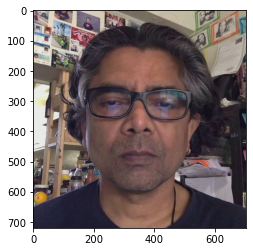

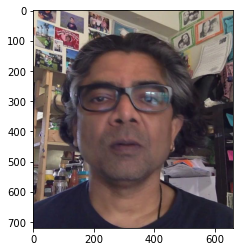

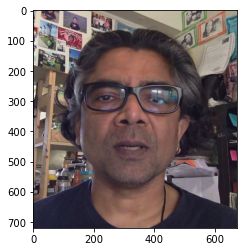

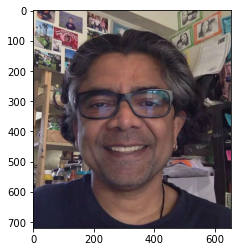

In [10]:
for img in my_face_images:
    with open(img, 'rb') as img_code:
        img_view_ready = Image.open(img_code)
        plt.figure()
        plt.imshow(img_view_ready)

https://github.com/Azure-Samples/cognitive-services-quickstart-code/blob/master/python/Face/DetectIdentifyFace.py

# Creating A Person Model Based on the 4 Faces 

In [11]:
PERSON_GROUP_ID = str(uuid.uuid4())
person_group_name = 'person-avkash'

In [12]:
## This code is taken from Azure face SDK 
## ---------------------------------------
def build_person_group(client, person_group_id, pgp_name):
    print('Create and build a person group...')
    # Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
    print('Person group ID:', person_group_id)
    client.person_group.create(person_group_id=person_group_id, name=person_group_id)

    # Create a person group person.
    my_face = client.person_group_person.create(person_group_id, pgp_name)
    # Find all jpeg images of human in working directory.
    my_face_images = [file for file in glob.glob('human-face/human-face*.jpeg')]
    # Add images to a Person object
    for image_p in my_face_images:
        with open(image_p, 'rb') as w:
            client.person_group_person.add_face_from_stream(person_group_id, my_face.person_id, w)

    # Train the person group, after a Person object with many images were added to it.
    client.person_group.train(person_group_id)

    # Wait for training to finish.
    while (True):
        training_status = client.person_group.get_training_status(person_group_id)
        print("Training status: {}.".format(training_status.status))
        if (training_status.status is TrainingStatusType.succeeded):
            break
        elif (training_status.status is TrainingStatusType.failed):
            client.person_group.delete(person_group_id=PERSON_GROUP_ID)
            sys.exit('Training the person group has failed.')
        time.sleep(5)


In [13]:
build_person_group(face_client, PERSON_GROUP_ID, person_group_name)


Create and build a person group...
Person group ID: 358c5273-f3c0-4870-af9c-4f6ba0a14b17
Training status: running.
Training status: succeeded.


# Making sure the person model has faces and they all belong to the same person

- We detect all faces in query image list, then add their face IDs to a new list.
- this face id list will be used later.

In [14]:
'''
Detect all faces in query image list, then add their face IDs to a new list.
'''
def detect_faces(client, query_images_list):
    print('Detecting faces in query images list...')

    face_ids = {} # Keep track of the image ID and the related image in a dictionary
    for image_name in query_images_list:
        image = open(image_name, 'rb') # BufferedReader
        print("Opening image: ", image.name)
        time.sleep(5)

        # Detect the faces in the query images list one at a time, returns list[DetectedFace]
        faces = client.face.detect_with_stream(image)  

        # Add all detected face IDs to a list
        for face in faces:
            print('Face ID', face.face_id, 'found in image', os.path.splitext(image.name)[0]+'.jpeg')
            # Add the ID to a dictionary with image name as a key.
            # This assumes there is only one face per image (since you can't have duplicate keys)
            face_ids[image.name] = face.face_id

    return face_ids

In [15]:
test_images = [file for file in glob.glob('human-face/human-face*.jpeg')]

In [16]:
test_images

['human-face/human-face1.jpeg',
 'human-face/human-face3.jpeg',
 'human-face/human-face2.jpeg',
 'human-face/human-face4.jpeg']

## Now let's view the face-specific thumbnails 

In [17]:
ids = detect_faces(face_client, test_images)

Detecting faces in query images list...
Opening image:  human-face/human-face1.jpeg
Face ID 1de09c73-e9b3-4a3f-bc5e-442591fe7050 found in image human-face/human-face1.jpeg
Opening image:  human-face/human-face3.jpeg
Face ID c2cb8a3a-60c4-481a-aa36-61f31da59abc found in image human-face/human-face3.jpeg
Opening image:  human-face/human-face2.jpeg
Face ID aa9da6aa-4f8c-439d-8c32-80bc3680bad7 found in image human-face/human-face2.jpeg
Opening image:  human-face/human-face4.jpeg
Face ID 74ffa1c2-8590-4757-9248-d754c4009f96 found in image human-face/human-face4.jpeg


In [18]:
ids

{'human-face/human-face1.jpeg': '1de09c73-e9b3-4a3f-bc5e-442591fe7050',
 'human-face/human-face3.jpeg': 'c2cb8a3a-60c4-481a-aa36-61f31da59abc',
 'human-face/human-face2.jpeg': 'aa9da6aa-4f8c-439d-8c32-80bc3680bad7',
 'human-face/human-face4.jpeg': '74ffa1c2-8590-4757-9248-d754c4009f96'}

### Verify that 2 random images from the list belong to the same person
- #### Note: So far, we have not used the face recognition part, only face detection

In [19]:
# Verification example for faces of the same person.
verify_result = face_client.face.verify_face_to_face(ids['human-face/human-face1.jpeg'], ids['human-face/human-face2.jpeg'])

In [20]:
if verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(verify_result.confidence))

Faces are of the same (Positive) person, similarity confidence: 0.92711.


## Matching face from ID card with face extracted by Video Analyzer 

In [21]:
def show_image_in_cell(face_url):
    response = requests.get(face_url)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(10,5))
    plt.imshow(img)
    plt.show()

In [22]:
dl_source_url = 'https://raw.githubusercontent.com/udacity/cd0461-building-computer-vision-solutions-with-azure-exercises/main/resources/ca-dl-sample.png'

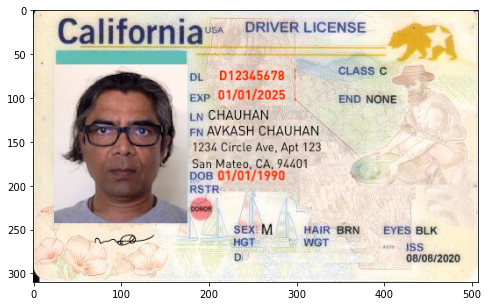

In [23]:
show_image_in_cell(dl_source_url)

In [24]:
## -------
## Reading file locally
## -------
# If I had image file locally, I would have used the following method:
# dl_image = open('/your-local-file-system/udacity/cal-dl.png', 'rb')
# dl_faces = face_client.face.detect_with_stream(dl_image)  

In [25]:
dl_faces = face_client.face.detect_with_url(dl_source_url) 

## Viewing Face ID and then saving it into the list of already saved Face IDs

In [26]:
for face in dl_faces:
    print('Face ID', face.face_id, 'found in image', dl_source_url)
    # Add the ID to a dictionary with image name as a key.
    # This assumes there is only one face per image (since you can't have duplicate keys)
    ids['ca-dl-sample.png'] = face.face_id

Face ID d47a2b3e-b1bc-42f0-b7c5-777d754c1875 found in image https://raw.githubusercontent.com/udacity/cd0461-building-computer-vision-solutions-with-azure-exercises/main/resources/ca-dl-sample.png


## Now we have 4 + 1 = 5 Face IDs in our face ID list

In [27]:
ids

{'human-face/human-face1.jpeg': '1de09c73-e9b3-4a3f-bc5e-442591fe7050',
 'human-face/human-face3.jpeg': 'c2cb8a3a-60c4-481a-aa36-61f31da59abc',
 'human-face/human-face2.jpeg': 'aa9da6aa-4f8c-439d-8c32-80bc3680bad7',
 'human-face/human-face4.jpeg': '74ffa1c2-8590-4757-9248-d754c4009f96',
 'ca-dl-sample.png': 'd47a2b3e-b1bc-42f0-b7c5-777d754c1875'}

## Perform Face Verification between the Face ID from the identity card and one of the Face IDs from the video

In [29]:
# Verification example for faces of the same person.
dl_verify_result = face_client.face.verify_face_to_face(ids['human-face/human-face4.jpeg'], ids['ca-dl-sample.png'])

In [30]:
if dl_verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(dl_verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(dl_verify_result.confidence))

Faces are of the same (Positive) person, similarity confidence: 0.79158.


In [31]:
ids['ca-dl-sample.png']

'd47a2b3e-b1bc-42f0-b7c5-777d754c1875'

In [32]:
ids.values()

dict_values(['1de09c73-e9b3-4a3f-bc5e-442591fe7050', 'c2cb8a3a-60c4-481a-aa36-61f31da59abc', 'aa9da6aa-4f8c-439d-8c32-80bc3680bad7', '74ffa1c2-8590-4757-9248-d754c4009f96', 'd47a2b3e-b1bc-42f0-b7c5-777d754c1875'])

In [33]:
dl_faces[0].face_rectangle.as_dict()

{'width': 99, 'height': 99, 'left': 53, 'top': 110}

In [34]:
# TAKEN FROM THE Azure SDK Sample
# Convert width height to a point in a rectangle
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    
    return ((left, top), (right, bottom))

In [35]:
def drawFaceRectangles(source_file, detected_face_object) :
    # Download the image from the url
    response = requests.get(source_file)
    img = Image.open(BytesIO(response.content))
    # Draw a red box around every detected faces
    draw = ImageDraw.Draw(img)
    for face in detected_face_object:
        draw.rectangle(getRectangle(face), outline='red', width = 10)
    return img

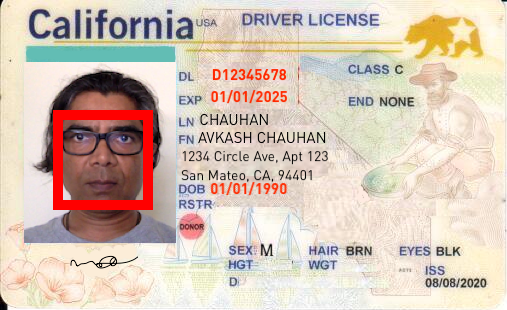

In [36]:
drawFaceRectangles(dl_source_url, dl_faces)

## Matching Face ID from identity card with Person Model 

In [37]:
# A list of Face ID
ids

{'human-face/human-face1.jpeg': '1de09c73-e9b3-4a3f-bc5e-442591fe7050',
 'human-face/human-face3.jpeg': 'c2cb8a3a-60c4-481a-aa36-61f31da59abc',
 'human-face/human-face2.jpeg': 'aa9da6aa-4f8c-439d-8c32-80bc3680bad7',
 'human-face/human-face4.jpeg': '74ffa1c2-8590-4757-9248-d754c4009f96',
 'ca-dl-sample.png': 'd47a2b3e-b1bc-42f0-b7c5-777d754c1875'}

## Using the face ID from the identify card and matching the identity with the Person Group model

In [40]:
# Enter the face ID of ca-dl-sample.png from the output of the cell above
get_the_face_id_from_the_driving_license = 'd47a2b3e-b1bc-42f0-b7c5-777d754c1875'

In [41]:
person_gp_results = face_client.face.identify([get_the_face_id_from_the_driving_license], PERSON_GROUP_ID)

In [42]:
for result in person_gp_results:
    for candidate in result.candidates:
        print("The Identity match confidence is {}".format(candidate.confidence))

The Identity match confidence is 0.82948
